# Comparison to colossus

This notebook compares `halox` implementations against the [`colossus`](https://bdiemer.bitbucket.io/colossus/index.html) library to validate the accuracy of our calculations.
Each comparison illustrate how to use `halox` to compute properties that are also present in `colossus`, and shows the agreement between the two libraries and their relative differences.

**Note:** These comparison are implemented as unit tests in the GitHub repository; see [Tests workflow](https://github.com/fkeruzore/halox/actions/workflows/tests.yml).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# halox imports
import halox
from halox import cosmology, nfw, hmf, bias

# colossus imports
from colossus.halo import profile_nfw
from colossus.lss import mass_function, peaks, bias as colossus_bias
import colossus.cosmology.cosmology as cc

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

We'll use a consistent cosmology for both libraries:

In [2]:
# Setup cosmologies for both libraries
cosmo_halox = cosmology.Planck18()
cosmo_colossus = "planck18"
cc.setCosmology(cosmo_colossus)

In [3]:
def create_comparison_plot():
    """Create a figure with gridspec layout: 2/3 top panel, 1/3 bottom panel"""
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)

    # Remove x-axis labels from main panel
    ax_main.tick_params(labelbottom=False)

    # Style both panels
    for ax in [ax_main, ax_ratio]:
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(True, alpha=1.0)

    return fig, ax_main, ax_ratio

## NFW Profile Comparisons

### NFW Density Profile

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/1904752067.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


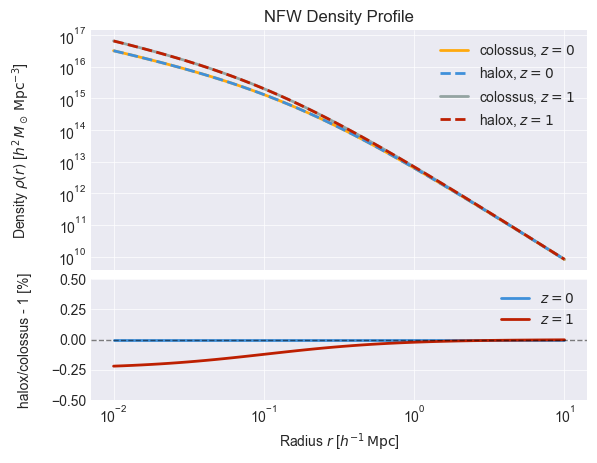

In [4]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
deltas = [200.0]
redshifts = [0.0, 1.0]

# Radial range
r = jnp.logspace(-2, 1, 50)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox, delta=deltas[0])
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    rho_halox[z] = nfw_halox.density(r)
    rho_colossus[z] = np.array(
        [nfw_colossus.density(ri * 1000) * 1e9 for ri in r]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    r,
    rho_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    r,
    rho_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    r,
    rho_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    r,
    rho_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("NFW Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[1.0] / rho_colossus[1.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(
    r, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    r, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-0.5, 0.5)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

### NFW Enclosed Mass

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/1031310215.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


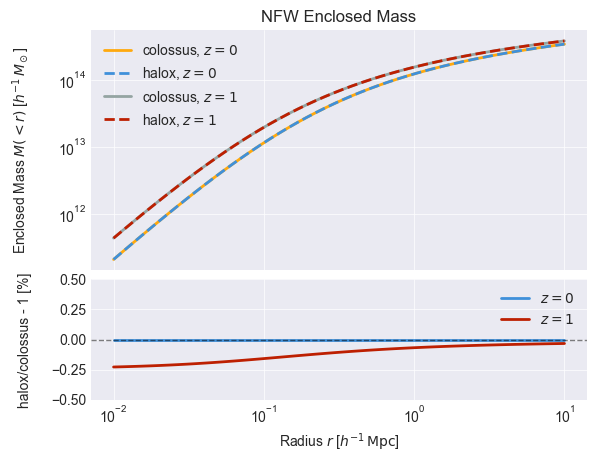

In [5]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox, delta=deltas[0])
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    mass_halox[z] = nfw_halox.enclosed_mass(r)
    mass_colossus[z] = np.array(
        [nfw_colossus.enclosedMass(ri * 1000) for ri in r]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    r,
    mass_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    r,
    mass_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    r,
    mass_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    r,
    mass_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("NFW Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[1.0] / mass_colossus[1.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(
    r, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    r, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-0.5, 0.5)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

### NFW Gravitational Potential

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/2032680323.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


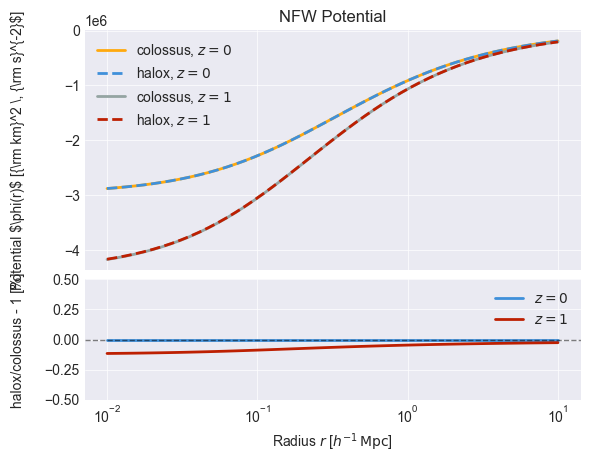

In [6]:
# Compute potential profiles for both redshifts
G = halox.cosmology.G
phi_halox = {}
phi_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox, delta=deltas[0])
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    phi_halox[z] = nfw_halox.potential(r)

    # For colossus, we need to compute manually using the formula from the test
    _r0 = nfw_colossus.par["rhos"] * 1e9  # Msun Mpc-3
    _rs = nfw_colossus.par["rs"] / 1e3  # Mpc
    phi_colossus[z] = -4 * jnp.pi * G * _r0 * _rs**3 * jnp.log(1 + r / _rs) / r

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(
    r,
    phi_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.semilogx(
    r,
    phi_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.semilogx(
    r,
    phi_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.semilogx(
    r,
    phi_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"Potential $\phi(r)$ [{\rm km}^2 \, {\rm s}^{-2}$]")
ax_main.set_title("NFW Potential")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (phi_halox[0.0] / phi_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (phi_halox[1.0] / phi_colossus[1.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(
    r, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    r, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-0.5, 0.5)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

## LSS and Halo Mass Function Comparisons

### RMS Variance σ(R,z)

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/1813244856.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


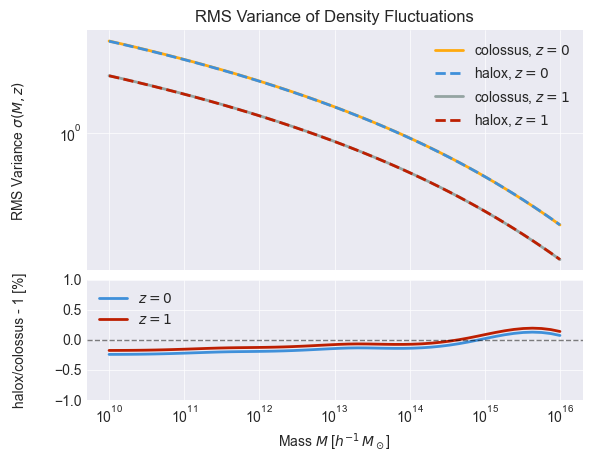

In [7]:
# Mass range and redshifts
masses = jnp.logspace(10, 16, 50)  # h-1 Msun
redshifts = [0.0, 1.0]

# Compute sigma values for both redshifts
sigma_halox = {}
sigma_colossus = {}

R_halox = hmf.mass_to_lagrangian_radius(masses, cosmo_halox)
R_colossus = np.array([peaks.lagrangianR(m) for m in masses])

cosmo_col_obj = cc.getCurrent()

for z in redshifts:
    sigma_halox[z] = np.array(
        [hmf.sigma_R(R_halox[i], z, cosmo_halox) for i in range(len(masses))]
    )
    sigma_colossus[z] = np.array(
        [cosmo_col_obj.sigma(R_colossus[i], z=z) for i in range(len(masses))]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    masses,
    sigma_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    masses,
    sigma_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    masses,
    sigma_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    masses,
    sigma_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"RMS Variance $\sigma(M,z)$")
ax_main.set_title("RMS Variance of Density Fluctuations")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (sigma_halox[0.0] / sigma_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (sigma_halox[1.0] / sigma_colossus[1.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(
    masses, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    masses, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-1.0, 1.0)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

### Tinker08 Multiplicity Function f(σ)

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/1707802687.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


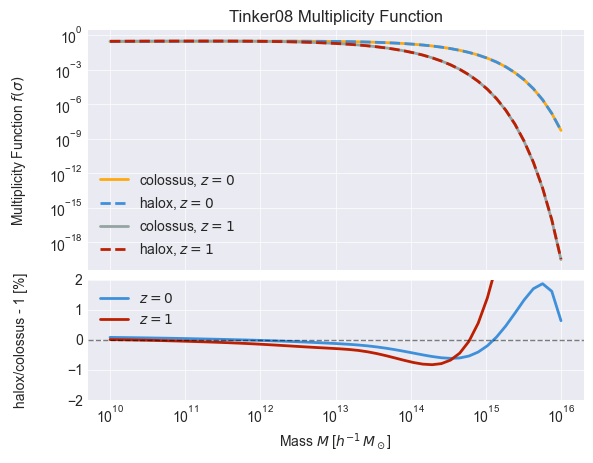

In [8]:
# Mass range and redshifts
masses = jnp.logspace(10, 16, 50)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# Compute f(sigma) for both redshifts
f_sigma_halox = {}
f_sigma_colossus = {}

for z in redshifts:
    f_sigma_halox[z] = np.array(
        [
            hmf.tinker08_f_sigma(m, z, cosmo=cosmo_halox, delta_c=delta_c)
            for m in masses
        ]
    )
    f_sigma_colossus[z] = np.array(
        [
            mass_function.massFunction(
                m,
                z,
                mdef=f"{delta_c:.0f}c",
                model="tinker08",
                q_in="M",
                q_out="f",
            )
            for m in masses
        ]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    masses,
    f_sigma_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    masses,
    f_sigma_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    masses,
    f_sigma_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    masses,
    f_sigma_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"Multiplicity Function $f(\sigma)$")
ax_main.set_title("Tinker08 Multiplicity Function")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (
    f_sigma_halox[0.0] / f_sigma_colossus[0.0] - 1.0
) * 100  # Convert to %
ratio_z1 = (
    f_sigma_halox[1.0] / f_sigma_colossus[1.0] - 1.0
) * 100  # Convert to %

ax_ratio.semilogx(
    masses, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    masses, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-2.0, 2.0)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

### Tinker08 Mass Function dn/d ln M

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/3660802383.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


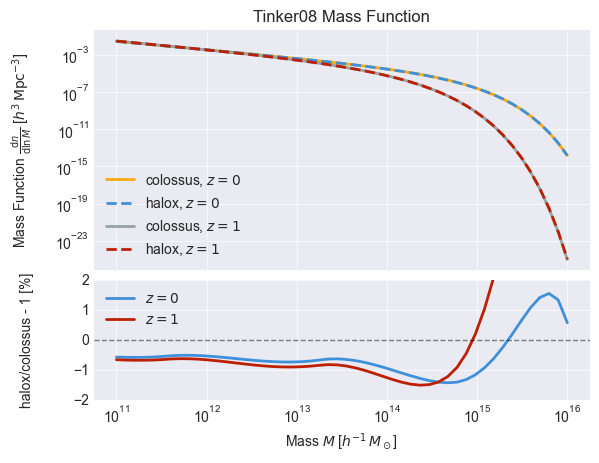

In [9]:
# Mass range and redshifts
masses = jnp.logspace(11, 16, 50)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# Compute mass functions for both redshifts
dn_dlnM_halox = {}
dn_dlnM_colossus = {}

for z in redshifts:
    dn_dlnM_halox[z] = hmf.tinker08_mass_function(
        masses, z, cosmo=cosmo_halox, delta_c=delta_c
    )
    dn_dlnM_colossus[z] = np.array(
        [
            mass_function.massFunction(
                m,
                z,
                mdef=f"{delta_c:.0f}c",
                model="tinker08",
                q_in="M",
                q_out="dndlnM",
            )
            for m in masses
        ]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    masses,
    dn_dlnM_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    masses,
    dn_dlnM_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(
    r"Mass Function $\frac{{\rm d}n}{{\rm d}\ln M}$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax_main.set_title("Tinker08 Mass Function")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (
    dn_dlnM_halox[0.0] / dn_dlnM_colossus[0.0] - 1.0
) * 100  # Convert to %
ratio_z1 = (
    dn_dlnM_halox[1.0] / dn_dlnM_colossus[1.0] - 1.0
) * 100  # Convert to %

ax_ratio.semilogx(
    masses, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    masses, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-2.0, 2.0)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()

### Tinker10 Halo Bias

/var/folders/3t/_vtqsjsx3hq7ktlc27qg58c00000gr/T/ipykernel_78292/3727196925.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


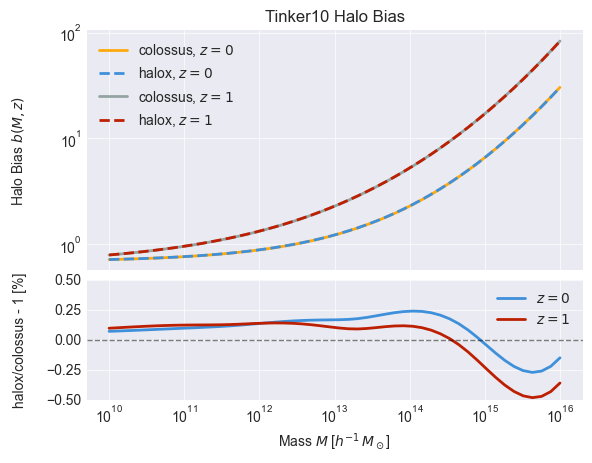

In [10]:
# Mass range and redshifts
masses = jnp.logspace(10, 16, 50)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# Compute halo bias for both redshifts
bias_halox = {}
bias_colossus = {}

for z in redshifts:
    bias_halox[z] = np.array(
        [
            bias.tinker10_bias(m, z, cosmo=cosmo_halox, delta_c=delta_c)
            for m in masses
        ]
    )
    bias_colossus[z] = np.array(
        [
            colossus_bias.haloBias(
                m, z, mdef=f"{delta_c:.0f}c", model="tinker10"
            )
            for m in masses
        ]
    )

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    masses,
    bias_colossus[0.0],
    color="C1",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=0$",
)
ax_main.loglog(
    masses,
    bias_halox[0.0],
    color="C0",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=0$",
)

# z=1.0
ax_main.loglog(
    masses,
    bias_colossus[1.0],
    color="C3",
    linestyle="-",
    linewidth=2,
    zorder=1,
    label="colossus, $z=1$",
)
ax_main.loglog(
    masses,
    bias_halox[1.0],
    color="C2",
    linestyle="--",
    linewidth=2,
    zorder=2,
    label="halox, $z=1$",
)

ax_main.set_ylabel(r"Halo Bias $b(M,z)$")
ax_main.set_title("Tinker10 Halo Bias")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (bias_halox[0.0] / bias_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (bias_halox[1.0] / bias_colossus[1.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(
    masses, ratio_z0, color="C0", linestyle="-", linewidth=2, label="$z=0$"
)
ax_ratio.semilogx(
    masses, ratio_z1, color="C2", linestyle="-", linewidth=2, label="$z=1$"
)

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox/colossus - 1 [%]")
ax_ratio.set_ylim(-0.5, 0.5)
ax_ratio.legend()

# Align y-axis labels
ax_main.yaxis.set_label_coords(-0.12, 0.5)
ax_ratio.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.show()